<a href="https://colab.research.google.com/github/bpriantti/Projeto_ML_Regressor_Volatilidade_em_15_dias_PETR4/blob/main/Projeto_ML_Regressor_Volatilidade_em_15_dias_PETR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto ML regressor - volatilidade em 15 dias - PETR4
____

__Bussines Problem:__
> Durante a rotina de investimentos torna-se importante a estimação da volatilidade tanto para estimar a variação de portfólios ou para operações estruturadas de compra ou venda de volatilidade, sendo necessário o desenvolvimento de modelos quantitativos para o forecasting futuro de movimentos de alta ou baixa de volatilidade.


__Objetivo:__   

> Desenvolver um modelo quantitativo de Machine Learning, utilizando o framework sklearn, statsmodels para o forecasting da volatilidade em 15 dias do ativo PETR4 listado na bolsa de valores brasileira B3.

__Autor:__  
   - Bruno Priantti.
    
__Contato:__  
  - b.priantti@outlook.com

__Encontre-me:__  
   -  https://www.linkedin.com/in/bpriantti/  
   -  https://github.com/bpriantti
   -  https://www.instagram.com/brunopriantti/
   


# Python Codes:
___

# install non-native libs:

In [ ]:
!pip install -q yfinance
!pip install -q talib-binary

# user functions: 


In [ ]:
#func para verificar estacionariedade das features:
#----------------------------------------------------------------
def stationary(series):
  result = adfuller(series)
  if(result[1] < 0.05):
    return 'stationary'
  else:
    return 'not stationary'
    
#func para eliminar correl entre features:
#----------------------------------------------------------------
def get_pair_above_threshold(X, threshold):
  correl = X.corr()
  correl = correl.abs().unstack()
  pairs_to_drop = set()
  cols = x.corr().columns
  for i in range(0, x.corr().shape[1]):
    for j in range(0, i+1):
      pairs_to_drop.add((cols[i], cols[j]))
  correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)
  return correl[correl > threshold].index


#import libs:

In [ ]:
#import libs:
import pandas as pd
import numpy as np

#libs para visualization dos dados:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import plotly.express as px
import plotly.graph_objects as Dash

#lib para api com ativos da bolsa:
import yfinance as yf
import talib as ta

#---
import warnings
warnings.filterwarnings("ignore")


# conexao api, request data base:

In [ ]:
# Download base de dados:
ticker = "PETR4.SA"

#datas - atentar para inicio em janeiro do ano de inicio do ativo ou proximo.
start =  "2017-01-01" 
end =    "2022-06-30"

#API - yahoo finance:
data = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,14.64,14.70,14.60,14.66,7.383341,7525700
2017-01-03,14.95,15.65,14.95,15.50,7.806398,39947800
2017-01-04,15.45,15.68,15.31,15.50,7.806398,37071700
2017-01-05,15.70,15.91,15.62,15.75,7.932308,47586300
2017-01-06,15.78,15.92,15.50,15.66,7.886982,25592000


In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-23,26.98,27.379999,26.120001,26.490000,21.570530,69262300
2022-06-24,26.76,27.090000,26.180000,26.290001,21.407673,53413400
2022-06-27,26.82,28.070000,26.660000,27.980000,22.783821,90417700
2022-06-28,28.58,28.830000,28.020000,28.330000,23.068823,51388000
2022-06-29,28.48,28.820000,27.840000,28.080000,22.865252,52048800


#visualizando dados de fechamento:

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(x=data.index, y=data['Adj Close']))

fig.update_layout(height=500, width=1000,
                 title_text="Adj Close - PETR4:",
                 yaxis_title="Adj Close Prices")
fig.show()

#calculando var. alvo:

In [ ]:
#set target var:
period = 16

data['returns'] = data['Adj Close'].pct_change()

data['vol_current'] = data['returns'].rolling(period).std()

data['target_volatility'] = data['vol_current'].shift(-period)

#visualizando o var. alvo:

In [ ]:
import plotly.graph_objects as go
    
fig = go.Figure(data=go.Scatter(x=data.index, y=data['target_volatility'], name = 'future vol'))

fig.add_trace(go.Scatter(x=data.index, y=data['vol_current'], name = 'current vol'))

fig.update_layout(height=500, width=1000,
                 title_text="Volatilidade 15 dias - PETR4: ")

fig.show()

In [ ]:
import plotly.graph_objects as go
    
fig = go.Figure(data=go.Histogram(x=data['target_volatility']))

fig.update_layout(height=600, width=1000,
                 title_text="Distribuição Volatilidade 15 dias - PETR4: ")

fig.show()

#calculando features de entrada:

In [ ]:
# vol 5
data['vol_5'] = data['Close'].pct_change().rolling(5).std()

# vol 10
data['vol_10'] = data['Close'].pct_change().rolling(10).std()

# vol 20
data['vol_20'] = data['Close'].pct_change().rolling(20).std()

# vol 30
data['vol_30'] = data['Close'].pct_change().rolling(30).std()

#mean_returns_5
data['mean_returns_5']  = data['Close'].pct_change().rolling(5).mean()

#mean_returns_10
data['mean_returns_10'] = data['Close'].pct_change().rolling(10).mean()

#mean_returns_20
data['mean_returns_20'] = data['Close'].pct_change().rolling(20).mean()

#mean_returns_30
data['mean_returns_30'] = data['Close'].pct_change().rolling(30).mean()

# Drop the missing values
data.dropna(inplace=True)

# Target
y = data['target_volatility'].copy()

# Features
x = data[['Open','High','Low','Close','vol_5','vol_10'
         ,'vol_20', 'vol_30', 'mean_returns_10', 'mean_returns_20','mean_returns_30']].copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1290 entries, 2017-03-30 to 2022-06-06
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1290 non-null   float64
 1   High               1290 non-null   float64
 2   Low                1290 non-null   float64
 3   Close              1290 non-null   float64
 4   Adj Close          1290 non-null   float64
 5   Volume             1290 non-null   int64  
 6   returns            1290 non-null   float64
 7   vol_current        1290 non-null   float64
 8   target_volatility  1290 non-null   float64
 9   vol_5              1290 non-null   float64
 10  vol_10             1290 non-null   float64
 11  vol_20             1290 non-null   float64
 12  vol_30             1290 non-null   float64
 13  mean_returns_5     1290 non-null   float64
 14  mean_returns_10    1290 non-null   float64
 15  mean_returns_20    1290 non-null   float64
 16  mean_r

#analisando estacionariedade das features:

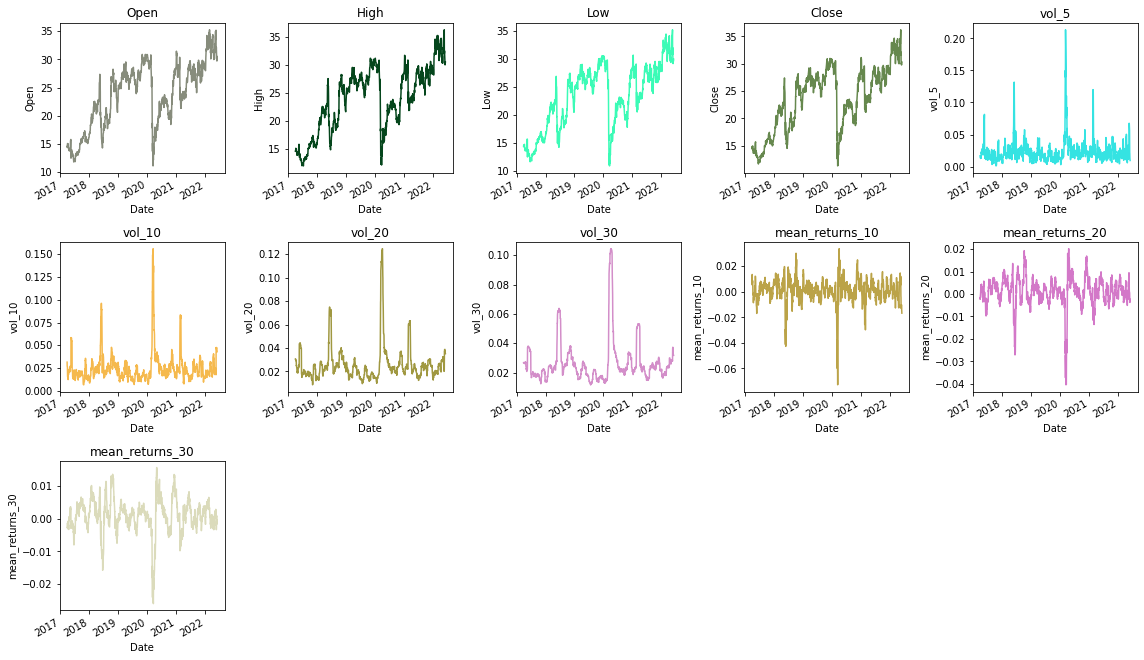

In [ ]:
i=1
nrows = int(x.shape[1]+1/3)
for feature in x.columns:
    plt.subplot(nrows, 5, i)
    # Plot the feature
    x[feature].plot(figsize=(16,3*x.shape[1]),
    color=np.random.rand(3,))
    plt.ylabel(feature)
    plt.title(feature)
    i+=1

plt.tight_layout()
plt.show()

check stationarity: 
Open is not stationary. Dropping it.
High is not stationary. Dropping it.
Low is not stationary. Dropping it.
Close is not stationary. Dropping it.
 
Index(['vol_5', 'vol_10', 'vol_20', 'vol_30', 'mean_returns_10',
       'mean_returns_20', 'mean_returns_30'],
      dtype='object')
 


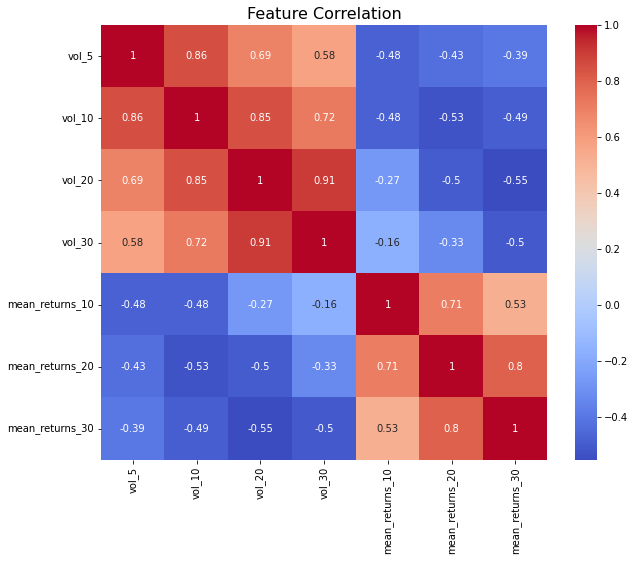

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("check stationarity: ")
for col in x.columns:
  if stationary(data[col]) == 'not stationary':
    print('%s is not stationary. Dropping it.' % col)
    x.drop(columns=[col], axis=1, inplace=True)

print(' ')
print(x.columns)
print(' ')
plt.figure(figsize=(10,8))
sns.heatmap(x.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation', fontsize = 16)
plt.show()

# train-test-val (Data Split):

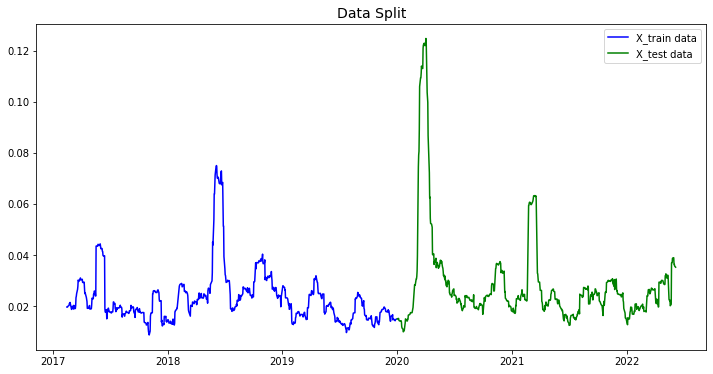

In [ ]:
#---------------------------------
s_train = "2017-01-01"
e_train = "2019-12-31"
#---------------------------------
s_test = "2020-01-01"
e_test = "2022-12-31"
#---------------------------------
x_train = x[s_train : e_train]
x_test  = x[s_test : e_test]
#---------------------------------
y_train = y[s_train : e_train]
y_test  = y[s_test : e_test]

#plot: 
plt.figure(figsize=(12, 6))
plt.plot(x_train['vol_20'],label='X_train data', color='blue')
plt.plot(x_test['vol_20'],label='X_test data', color='green')

#set labels:
plt.title("Data Split",fontsize=14)

#display:
plt.legend()
plt.show()

#PCA:

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Padronaziçao a base 
sc = StandardScaler()

#---
x_train_pca = sc.fit_transform(x_train)
x_test_pca  = sc.transform(x_test)

# Aplicando a PCA
pca = PCA(n_components = 6)
pcas = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"]

#---
x_train_pca = pca.fit_transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)

#---
#print(vars(pca))
explained_variance = pca.explained_variance_ratio_
print(sum(explained_variance))


0.990429527776568


#correl analise:

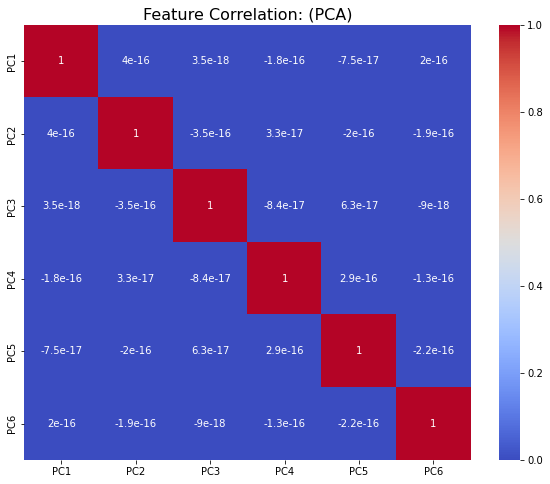

In [ ]:
x_train_pca_data = pd.DataFrame(data = x_train_pca)
x_train_pca_data = x_train_pca_data.set_index(x_train.index)

x_train_pca_data.columns = pcas

x_test_pca_data = pd.DataFrame(data = x_test_pca)
x_test_pca_data = x_test_pca_data.set_index(x_test.index)
x_test_pca_data.columns = pcas

plt.figure(figsize=(10,8))
sns.heatmap(x_train_pca_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation: (PCA)', fontsize = 16)
plt.show()

# model training:

In [ ]:
# Treinando o modelo com statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

#---
x_train_ = sm.add_constant(x_train_pca)
x_test_  = sm.add_constant(x_test_pca)

#---
lr_sm = sm.OLS(y_train, x_train_).fit() # Linha que treina o modelo

#---
y_pred_train = lr_sm.predict(x_train_)
y_pred_test  = lr_sm.predict(x_test_)

#---
print(lr_sm.summary())

                            OLS Regression Results                            
Dep. Variable:      target_volatility   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     22.41
Date:                Tue, 16 Aug 2022   Prob (F-statistic):           3.00e-24
Time:                        23:49:50   Log-Likelihood:                 2270.4
No. Observations:                 718   AIC:                            -4527.
Df Residuals:                     711   BIC:                            -4495.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0228      0.000     59.367      0.0

#model evaluation:

In [ ]:
# Avaliaçao dos resultados com statsmodels

MAE_train_sm = sm.tools.eval_measures.meanabs(y_train, y_pred_train)
R2_train_sm = lr_sm.rsquared 
RMSE_train_sm = sm.tools.eval_measures.rmse(y_train, y_pred_train)

print("----- Avaliação do treinamento -----")
print("MAE: ", round(MAE_train_sm, 3))
print('R2: ', round(R2_train_sm, 3))
print('RMSE: ', round(RMSE_train_sm, 3))

MAE_test_sm = sm.tools.eval_measures.meanabs(y_test, y_pred_test) 
RMSE_test_sm = sm.tools.eval_measures.rmse(y_test, y_pred_test)

print("")
print("----- Avaliação do teste -----")
print("MAE: ", round(MAE_test_sm, 3))
print('RMSE: ', round(RMSE_test_sm, 3))

----- Avaliação do treinamento -----
MAE:  0.007
R2:  0.159
RMSE:  0.01

----- Avaliação do teste -----
MAE:  0.009
RMSE:  0.019


In [ ]:
from sklearn import metrics

print("A volatilidade média da base é: ")
print(round(y_test.mean(), 3))
print()
print("O percentual do MAE em relaçao à média da base: ")
print(round(metrics.mean_absolute_error(y_test, y_pred_test)/y_test.mean()*100, 2))

A volatilidade média da base é: 
0.028

O percentual do MAE em relaçao à média da base: 
32.75


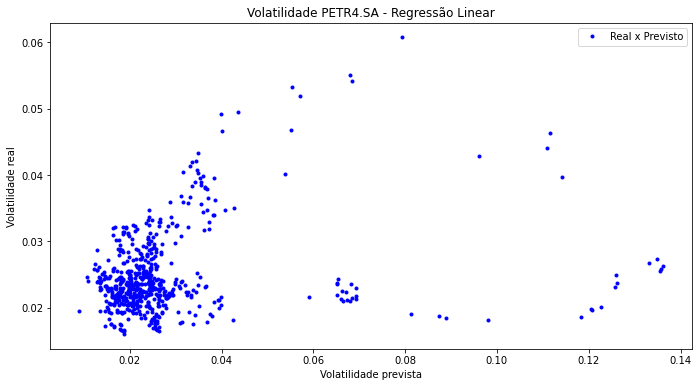

In [ ]:
# Gráfico dos resultados

plt.figure(figsize = (11.5, 6))
plt.plot(y_test, y_pred_test, ".", color = "blue", label = "Real x Previsto")
plt.legend()
plt.xlabel("Volatilidade prevista")
plt.ylabel("Volatilidade real")
plt.title("Volatilidade " + ticker + " - Regressão Linear");


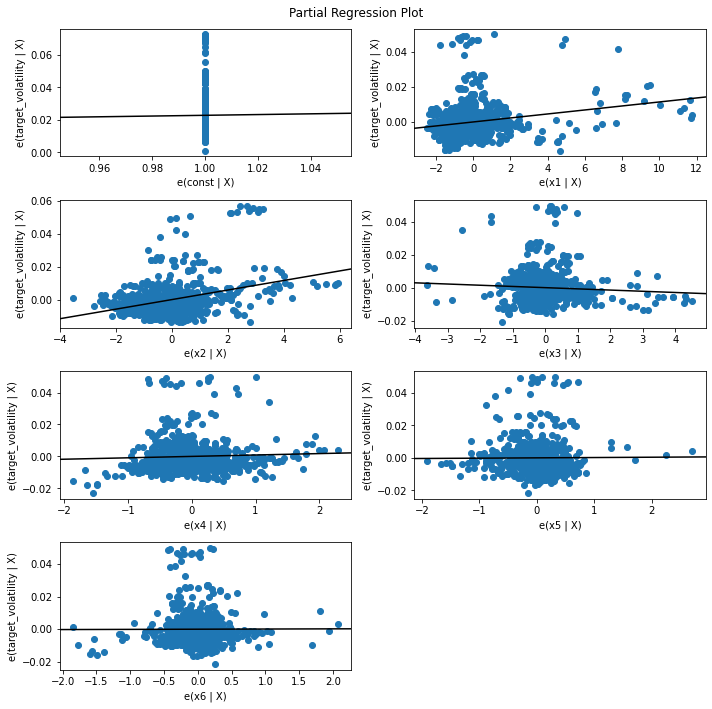

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize = (10, 10))

fig = sm.graphics.plot_partregress_grid(lr_sm, fig = fig)

# model performance signal:

In [ ]:
# Resultados: Real x previsto em um dataframe
sinal_data = pd.DataFrame({'Real': y_test, 'Previsto': y_pred_test})

sinal_data["Real_lag"] = sinal_data["Real"]
sinal_data["Previsto_lag"] = sinal_data["Previsto"].shift(-15)


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1
                   ,shared_xaxes=True
                   ,vertical_spacing=0.02)

fig.add_trace(go.Scatter(x=sinal_data.index, y = sinal_data["Real_lag"]),
              row=1, col=1)

fig.add_trace(go.Scatter(x=sinal_data.index, y = sinal_data["Previsto_lag"]),
              row=1, col=1)


fig.update_layout(height=600, width=1000,
                  title_text="Volatilidade 15 dias - PETR4 ( Real x Previsto):")

fig.show()